In [5]:
import tensorflow as tf
import os
from matplotlib import pyplot as plt
# from IPython import display
# from IPython.display import clear_output

from google.colab import drive
drive.mount('/content/drive/')
# path = "/content/drive/My Drive/HDSP/PnP-ADMM"
path = "/content/drive/My Drive/DATA"
os.chdir(path)

from os import listdir
from os.path import isfile, join

import numpy as np
import keras
import scipy.io
import pandas as pd
from scipy.io import loadmat

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
tf.random.set_seed(
    1234
)
#---------------------defined function used -------------------------------------------------------------------


# Defined protocol of input and ouput (it is recommended only read, not applied operator here, but it is possible)
def Input_image(image):
    images = loadmat(image).get('y')
    images = np.expand_dims(images,-1)
    # procesamiento
    return images/np.max(images)

def Oput_image(image):
    images = loadmat(image).get('y_m')
    images = np.expand_dims(images, -1)
    return images/np.max(images)

def load_sambles(data):
  data = data[['inimg']]
  inimg_name = list(data.iloc[:,0])
  samples = []
  for samp in inimg_name:
    samples.append(samp)
  return samples


class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, samples,PATH,batch_size=1,dim_input=(512, 512, 3), shuffle=True, dim_oput=(512, 512, 3)):
        'Initialization'
        self.dim_input = dim_input
        self.dim_oput = dim_oput
        self.batch_size = batch_size
        self.list_images = samples
        self.shuffle = shuffle
        self.PATH = PATH
        self.on_epoch_end()


    # falta __data_generation
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(len(self.list_images) / self.batch_size)

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Find list of IDs
        images_name = [self.list_images[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(images_name)

        return X, y

    def on_epoch_end(self):
        'Update indexes after each epoch'
        self.indexes = np.arange(len(self.list_images))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, images_names):
        'Generates data containing batch_size samples'  # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim_input))  # Array de numpy con zeros de tamaño
        y = np.empty((self.batch_size, *self.dim_oput))
        # Generate data
        for i, file_name in enumerate(images_names):
            # Store sample
            X[i,] = Input_image(self.PATH + '/' + file_name)
            # Store class
            y[i,] = Oput_image(self.PATH + '/' + file_name)
        return X, y



def Build_data_set(IMG_WIDTH,IMG_HEIGHT,L_bands,L_imput,BATCH_SIZE,PATH,split_v):

  # Random split
  data_dir_list = os.listdir(PATH)
  N = len(data_dir_list)
  train_df = pd.DataFrame(columns=['inimg'])
  test_df = pd.DataFrame(columns=['inimg'])
  randurls = np.copy(data_dir_list)
  train_n = round(N * split_v)
  np.random.shuffle(randurls)
  tr_urls = randurls[:train_n]
  ts_urls = randurls[train_n:N]
  for i in tr_urls:
      train_df = train_df.append({'inimg': i}, ignore_index=True)
  for i in ts_urls:
      test_df = test_df.append({'inimg': i}, ignore_index=True)

  params = {'dim_input': (IMG_WIDTH, IMG_HEIGHT, L_imput),
            'dim_oput': (IMG_WIDTH, IMG_HEIGHT, L_bands),
            'batch_size': BATCH_SIZE,
            'PATH': PATH,
            'shuffle': True}

  partition_Train = load_sambles(test_df)
  partition_Test = load_sambles(train_df)

  train_generator = DataGenerator(partition_Train, **params)
  test_generator = DataGenerator(partition_Test, **params)

  train_dataset = tf.data.Dataset.from_generator(
      lambda: train_generator,
      (tf.float32, tf.float32))

  test_dataset = tf.data.Dataset.from_generator(
      lambda: test_generator,
      (tf.float32, tf.float32))

  return train_dataset,test_dataset

def PSNR_Metric(y_true, y_pred):
  return tf.reduce_mean(tf.image.psnr(y_true,y_pred,tf.reduce_max(y_true)))

# os.environ["CUDA_VISIBLE_DEVICES"]= '1'
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   try:
#     # Currently, memory growth needs to be the same across GPUs
#     for gpu in gpus:
#       tf.config.experimental.set_memory_growth(gpu, True)
#     logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#     print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#   except RuntimeError as e:
#     # Memory growth must be set before GPUs have been initialized
#     print(e)

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)
# !pwd
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))


#----------------------------- directory of the spectral data set -------------------------                              # for windows
BATCH_SIZE = 1; L_bands    = 1; L_imput    = 1;
from scipy.io import loadmat
# from recoverynet import *     # Net build


#########################################################################################

ARAD = False # @ {type:"boolean"} ### IF TRUE MODIFIY NETWORK
if ARAD:
  IMG_WIDTH = 286; IMG_HEIGHT = 256;
  path_files  = os.getcwd()+'/ARAD/Y'
  nI = 10
else:
  IMG_WIDTH = 535; IMG_HEIGHT = 512;
  path_files  = os.getcwd()+'/REAL/Y'
  nI = 14
reTrain = False # @ {type:"boolean"}
gf=0.0  # @ {type:"raw"}
awgn=25 # @ {type:"raw"}
lr = 1e-4# @ {type:"raw"}
batch =  nI# @ {type:"raw"}

norm_inp="NO-F"  # @ {type:"raw"}
norm_out="NO-F"  # @ {type:"raw"}
loss =  'mean_squared_error'# @ {type:"string"}
model_path=os.getcwd()
net = "NO-NO"
old_cp_dir=model_path+'/Weights/Ruben/' #@param {type:"raw"}
# if ARAD:
#     old_cp_dir += 'ARAD_'+str(gf)+'_'+str(awgn)+'_'+net+'/'
# else:
#     old_cp_dir += 'REAL/'




#########################################################################################

optimizad = tf.keras.optimizers.Adam(learning_rate=lr, amsgrad=False)

# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=new_cp_path,
#     save_weights_only=True,
#     verbose=1,
#     save_freq='epoch',
#     monitor='PSNR_Metric',
#     mode='max',
#     save_best_only=True)



Y_inp = None
for s in range(nI):
  if norm_inp!="" and ARAD:
    Temp = np.array(loadmat(path_files + '/y_ideal_'+str(s+1)+'_'+norm_inp)['y_ideal'])
  else:
    Temp = np.array(loadmat(path_files + '/y_ideal_'+str(s+1))['y_ideal'])
  if Y_inp is None:
    Y_inp = np.expand_dims(Temp, 0)
  else:
    Y_inp = np.concatenate((Y_inp, np.expand_dims(Temp, 0)),0)

Y_oup = None
for s in range(nI):
  if norm_out!="" and ARAD:
    Temp = np.array(loadmat(path_files + '/y_real_m_'+str(s+1)+'_'+str(gf)+'_'+str(awgn)+'_'+norm_out)['y_real_m'])
  elif ARAD:
    Temp = np.array(loadmat(path_files + '/y_real_m_'+str(s+1)+'_'+str(gf)+'_'+str(awgn))['y_real_m'])
  else:
    Temp = np.array(loadmat(path_files + '/y_real_'+str(s+1))['y_real'])
  if Y_oup is None:
    Y_oup = np.expand_dims(Temp, 0)
  else:
    Y_oup = np.concatenate((Y_oup, np.expand_dims(Temp, 0)),0)

Y_inp = np.expand_dims(Y_inp, -1)
Y_oup = np.expand_dims(Y_oup, -1)

Mounted at /content/drive/
Not connected to a GPU
Your runtime has 13.6 gigabytes of available RAM



In [2]:
#@markdown UNet - Base
def UNetL2(pretrained_weights=None, input_size=(256, 256, 12)):

    inputs = Input(input_size)
    L = 16;
    L_2 = 2 * L;
    L_3 = 3 * L;
    L_4 = 4 * L;
    conv1 = Conv2D(L, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(L, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(L_2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(L_2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(L_3, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(L_3, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    # drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(L_4, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(L_4, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    # drop4 = Dropout(0.5)(conv4)

    up5 = Conv2D(L_3, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv4))
    up5 = Conv2DTranspose(L_3,[1,2],activation='relu')(up5)
    merge5 = concatenate([conv3, up5], axis=3)
    conv5 = Conv2D(L_3, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge5)
    conv5 = Conv2D(L_3, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)

    up6 = Conv2D(L_2, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv5))
    up6 = Conv2DTranspose(L_2, [1, 2], activation='relu')(up6)
    merge6 = concatenate([conv2, up6], axis=3)
    conv6 = Conv2D(L_2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(L_2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = Conv2D(L, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv6))
    up7 = Conv2DTranspose(L, [1, 2], activation='relu')(up7) #OFF PARA ARAD
    merge7 = concatenate([conv1, up7], axis=3)
    conv7 = Conv2D(L, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(L, 3, activation='relu', padding='same', kernel_initializer='he_normal', )(conv7)

    final = Conv2D(1, 1)(conv7)


    model = Model(inputs, final)

    if (pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

In [7]:
!pip install visualkeras
import visualkeras
a = visualkeras.layered_view(UNetL2(input_size=(IMG_HEIGHT,IMG_WIDTH,L_bands)))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


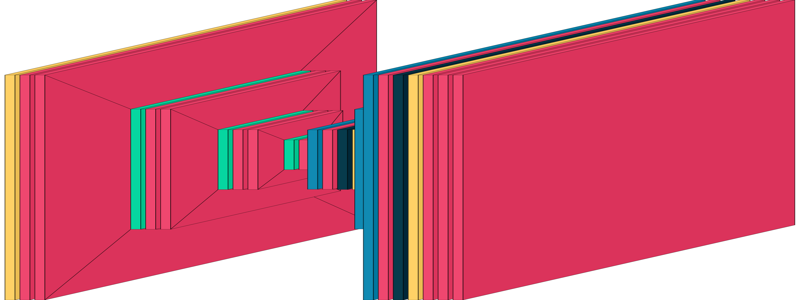

In [9]:
a.resize((800,300))

In [ ]:

epochs =  1000# @param {type:"number"}

#-------------Net_model----------------------------------------------------------------
model = 
model.compile(optimizer=optimizad, loss=loss,metrics = [PSNR_Metric])
history = model.fit(x=Y_inp,y=Y_oup, epochs=epochs)#, callbacks=[model_checkpoint_callback])
last_psnr=history.history['PSNR_Metric'][-1]
best_psnr=np.max(history.history['PSNR_Metric'])
iter_psnr=history.history['PSNR_Metric'].index(best_psnr)
best_loss=np.min(history.history['loss'])
iter_loss=history.history['loss'].index(best_loss)
name="Base" # @param {type:"string"}
name+=', '+str(best_psnr)+', '+str(best_loss)+', '+str(epochs)+'.h5'
print(name)
model.save(old_cp_dir+name)

#.------------ seee the accfuracy---------------
plt.plot(history.history['loss'], label='loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.show()
plt.plot(history.history['PSNR_Metric'], label='PSNR_Metric')
plt.xlabel('Epoch')
plt.ylabel('PSNR_Metric')
plt.show()

In [ ]:
#@markdown UNet - NO padd
def UNetL2(pretrained_weights=None, input_size=(256, 256, 12)):

    inputs = Input(input_size)
    L = 16;
    L_2 = 2 * L;
    L_3 = 3 * L;
    L_4 = 4 * L;
    conv1 = Conv2D(L, 3, activation='relu', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(L, 3, activation='relu', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(L_2, 3, activation='relu', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(L_2, 3, activation='relu', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(L_3, 3, activation='relu', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(L_3, 3, activation='relu', kernel_initializer='he_normal')(conv3)
    # drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(L_4, 3, activation='relu', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(L_4, 3, activation='relu', kernel_initializer='he_normal')(conv4)
    # drop4 = Dropout(0.5)(conv4)

    up5 = Conv2D(L_3, 2, activation='relu', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv4))
    up5 = Conv2DTranspose(L_3,[1,2],activation='relu')(up5)
    up5 = tf.keras.layers.Resizing(121, 126, interpolation="bilinear", crop_to_aspect_ratio=False)(up5)

    merge5 = concatenate([conv3, up5], axis=3)
    conv5 = Conv2D(L_3, 3, activation='relu', kernel_initializer='he_normal')(merge5)
    conv5 = Conv2D(L_3, 3, activation='relu', kernel_initializer='he_normal')(conv5)

    up6 = Conv2D(L_2, 2, activation='relu', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv5))
    up6 = Conv2DTranspose(L_2, [1, 2], activation='relu')(up6)
    up6 = tf.keras.layers.Resizing(250, 261, interpolation="bilinear", crop_to_aspect_ratio=False)(up6)
    merge6 = concatenate([conv2, up6], axis=3)
    conv6 = Conv2D(L_2, 3, activation='relu', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(L_2, 3, activation='relu', kernel_initializer='he_normal')(conv6)

    up7 = Conv2D(L, 2, activation='relu', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv6))
    up7 = Conv2DTranspose(L, [1, 2], activation='relu')(up7) #OFF PARA ARAD
    up7 = tf.keras.layers.Resizing(508, 531, interpolation="bilinear", crop_to_aspect_ratio=False)(up7)
    merge7 = concatenate([conv1, up7], axis=3)
    conv7 = Conv2D(L, 3, activation='relu', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(L, 3, activation='relu', kernel_initializer='he_normal', )(conv7)
    conv7 = tf.keras.layers.Resizing(512, 535, interpolation="bilinear", crop_to_aspect_ratio=False)(conv7)
    final = Conv2D(1, 1)(conv7)


    model = Model(inputs, final)

    if (pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

In [ ]:

epochs =  1000# @param {type:"number"}

#-------------Net_model----------------------------------------------------------------
model = UNetL2(input_size=(IMG_HEIGHT,IMG_WIDTH,L_bands))
# model.summary()
model.compile(optimizer=optimizad, loss=loss,metrics = [PSNR_Metric])
history = model.fit(x=Y_inp,y=Y_oup, epochs=epochs)#, callbacks=[model_checkpoint_callback])
last_psnr=history.history['PSNR_Metric'][-1]
best_psnr=np.max(history.history['PSNR_Metric'])
iter_psnr=history.history['PSNR_Metric'].index(best_psnr)
best_loss=np.min(history.history['loss'])
iter_loss=history.history['loss'].index(best_loss)
name="No_Padding" # @param {type:"string"}
name+=', '+str(best_psnr)+', '+str(best_loss)+', '+str(epochs)+'.h5'
print(name)
model.save(old_cp_dir+name)

#.------------ seee the accfuracy---------------
plt.plot(history.history['loss'], label='loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.show()
plt.plot(history.history['PSNR_Metric'], label='PSNR_Metric')
plt.xlabel('Epoch')
plt.ylabel('PSNR_Metric')
plt.show()

In [ ]:
#@markdown UNet - Batch Padd
def UNetL2(pretrained_weights=None, input_size=(256, 256, 12)):

    inputs = Input(input_size)
    L = 16;
    L_2 = 2 * L;
    L_3 = 3 * L;
    L_4 = 4 * L;
    conv1 = Conv2D(L, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(L, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(L_2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(L_2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(L_3, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(L_3, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(L_4, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(L_4, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    # drop4 = Dropout(0.5)(conv4)
    conv4 = BatchNormalization()(conv4)
    up5 = Conv2D(L_3, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv4))
    up5 = Conv2DTranspose(L_3,[1,2],activation='relu')(up5)
    merge5 = concatenate([conv3, up5], axis=3)
    conv5 = Conv2D(L_3, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge5)
    conv5 = Conv2D(L_3, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    conv5 = BatchNormalization()(conv5)
    up6 = Conv2D(L_2, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv5))
    up6 = Conv2DTranspose(L_2, [1, 2], activation='relu')(up6)
    merge6 = concatenate([conv2, up6], axis=3)
    conv6 = Conv2D(L_2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(L_2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
    conv6 = BatchNormalization()(conv6)
    up7 = Conv2D(L, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv6))
    up7 = Conv2DTranspose(L, [1, 2], activation='relu')(up7) #OFF PARA ARAD
    merge7 = concatenate([conv1, up7], axis=3)
    conv7 = Conv2D(L, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(L, 3, activation='relu', padding='same', kernel_initializer='he_normal', )(conv7)

    final = Conv2D(1, 1)(conv7)


    model = Model(inputs, final)

    if (pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

In [ ]:

epochs =  1000# @param {type:"number"}

#-------------Net_model----------------------------------------------------------------
model = UNetL2(input_size=(IMG_HEIGHT,IMG_WIDTH,L_bands))
model.compile(optimizer=optimizad, loss=loss,metrics = [PSNR_Metric])
history = model.fit(x=Y_inp,y=Y_oup, epochs=epochs)#, callbacks=[model_checkpoint_callback])
last_psnr=history.history['PSNR_Metric'][-1]
best_psnr=np.max(history.history['PSNR_Metric'])
iter_psnr=history.history['PSNR_Metric'].index(best_psnr)
best_loss=np.min(history.history['loss'])
iter_loss=history.history['loss'].index(best_loss)
name="Batch_Padd" # @param {type:"string"}
name+=', '+str(best_psnr)+', '+str(best_loss)+', '+str(epochs)+'.h5'
print(name)
model.save(old_cp_dir+name)

#.------------ seee the accfuracy---------------
plt.plot(history.history['loss'], label='loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.show()
plt.plot(history.history['PSNR_Metric'], label='PSNR_Metric')
plt.xlabel('Epoch')
plt.ylabel('PSNR_Metric')
plt.show()

In [ ]:
#@markdown UNet - Variance Scaling - Padd
def UNetL2(pretrained_weights=None, input_size=(256, 256, 12)):

    init = tf.keras.initializers.VarianceScaling(
      scale=1.0,
      mode='fan_in',
      distribution='truncated_normal',
      seed=None
    )
    inputs = Input(input_size)
    L = 16;
    L_2 = 2 * L;
    L_3 = 3 * L;
    L_4 = 4 * L;
    conv1 = Conv2D(L, 3, activation='relu', padding='same', kernel_initializer=init)(inputs)
    conv1 = Conv2D(L, 3, activation='relu', padding='same', kernel_initializer=init)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(L_2, 3, activation='relu', padding='same', kernel_initializer=init)(pool1)
    conv2 = Conv2D(L_2, 3, activation='relu', padding='same', kernel_initializer=init)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(L_3, 3, activation='relu', padding='same', kernel_initializer=init)(pool2)
    conv3 = Conv2D(L_3, 3, activation='relu', padding='same', kernel_initializer=init)(conv3)
    # drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(L_4, 3, activation='relu', padding='same', kernel_initializer=init)(pool3)
    conv4 = Conv2D(L_4, 3, activation='relu', padding='same', kernel_initializer=init)(conv4)
    # drop4 = Dropout(0.5)(conv4)

    up5 = Conv2D(L_3, 2, activation='relu', padding='same', kernel_initializer=init)(
        UpSampling2D(size=(2, 2))(conv4))
    up5 = Conv2DTranspose(L_3,[1,2],activation='relu')(up5)
    merge5 = concatenate([conv3, up5], axis=3)
    conv5 = Conv2D(L_3, 3, activation='relu', padding='same', kernel_initializer=init)(merge5)
    conv5 = Conv2D(L_3, 3, activation='relu', padding='same', kernel_initializer=init)(conv5)

    up6 = Conv2D(L_2, 2, activation='relu', padding='same', kernel_initializer=init)(
        UpSampling2D(size=(2, 2))(conv5))
    up6 = Conv2DTranspose(L_2, [1, 2], activation='relu')(up6)
    merge6 = concatenate([conv2, up6], axis=3)
    conv6 = Conv2D(L_2, 3, activation='relu', padding='same', kernel_initializer=init)(merge6)
    conv6 = Conv2D(L_2, 3, activation='relu', padding='same', kernel_initializer=init)(conv6)

    up7 = Conv2D(L, 2, activation='relu', padding='same', kernel_initializer=init)(
        UpSampling2D(size=(2, 2))(conv6))
    up7 = Conv2DTranspose(L, [1, 2], activation='relu')(up7) #OFF PARA ARAD
    merge7 = concatenate([conv1, up7], axis=3)
    conv7 = Conv2D(L, 3, activation='relu', padding='same', kernel_initializer=init)(merge7)
    conv7 = Conv2D(L, 3, activation='relu', padding='same', kernel_initializer=init, )(conv7)

    final = Conv2D(1, 1)(conv7)


    model = Model(inputs, final)

    if (pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

In [ ]:

epochs =  1000# @param {type:"number"}

#-------------Net_model----------------------------------------------------------------
model = UNetL2(input_size=(IMG_HEIGHT,IMG_WIDTH,L_bands))
model.compile(optimizer=optimizad, loss=loss,metrics = [PSNR_Metric])
history = model.fit(x=Y_inp,y=Y_oup, epochs=epochs)#, callbacks=[model_checkpoint_callback])
last_psnr=history.history['PSNR_Metric'][-1]
best_psnr=np.max(history.history['PSNR_Metric'])
iter_psnr=history.history['PSNR_Metric'].index(best_psnr)
best_loss=np.min(history.history['loss'])
iter_loss=history.history['loss'].index(best_loss)
name="VarianceScaling_Padd" # @param {type:"string"}
name+=', '+str(best_psnr)+', '+str(best_loss)+', '+str(epochs)+'.h5'
print(name)
model.save(old_cp_dir+name)

#.------------ seee the accfuracy---------------
plt.plot(history.history['loss'], label='loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.show()
plt.plot(history.history['PSNR_Metric'], label='PSNR_Metric')
plt.xlabel('Epoch')
plt.ylabel('PSNR_Metric')
plt.show()

In [ ]:
#@markdown UNet - Variance Scaling - Padd - Batch
def UNetL2(pretrained_weights=None, input_size=(256, 256, 12)):

    init = tf.keras.initializers.VarianceScaling(
      scale=1.0,
      mode='fan_in',
      distribution='truncated_normal',
      seed=None
    )
    inputs = Input(input_size)
    L = 16;
    L_2 = 2 * L;
    L_3 = 3 * L;
    L_4 = 4 * L;
    conv1 = Conv2D(L, 3, activation='relu', padding='same', kernel_initializer=init)(inputs)
    conv1 = Conv2D(L, 3, activation='relu', padding='same', kernel_initializer=init)(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(L_2, 3, activation='relu', padding='same', kernel_initializer=init)(pool1)
    conv2 = Conv2D(L_2, 3, activation='relu', padding='same', kernel_initializer=init)(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(L_3, 3, activation='relu', padding='same', kernel_initializer=init)(pool2)
    conv3 = Conv2D(L_3, 3, activation='relu', padding='same', kernel_initializer=init)(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(L_4, 3, activation='relu', padding='same', kernel_initializer=init)(pool3)
    conv4 = Conv2D(L_4, 3, activation='relu', padding='same', kernel_initializer=init)(conv4)
    conv4 = BatchNormalization()(conv4)
    up5 = Conv2D(L_3, 2, activation='relu', padding='same', kernel_initializer=init)(
        UpSampling2D(size=(2, 2))(conv4))
    up5 = Conv2DTranspose(L_3,[1,2],activation='relu')(up5)
    merge5 = concatenate([conv3, up5], axis=3)
    conv5 = Conv2D(L_3, 3, activation='relu', padding='same', kernel_initializer=init)(merge5)
    conv5 = Conv2D(L_3, 3, activation='relu', padding='same', kernel_initializer=init)(conv5)

    conv5 = BatchNormalization()(conv5)
    up6 = Conv2D(L_2, 2, activation='relu', padding='same', kernel_initializer=init)(
        UpSampling2D(size=(2, 2))(conv5))
    up6 = Conv2DTranspose(L_2, [1, 2], activation='relu')(up6)
    merge6 = concatenate([conv2, up6], axis=3)
    conv6 = Conv2D(L_2, 3, activation='relu', padding='same', kernel_initializer=init)(merge6)
    conv6 = Conv2D(L_2, 3, activation='relu', padding='same', kernel_initializer=init)(conv6)

    conv6 = BatchNormalization()(conv6)
    up7 = Conv2D(L, 2, activation='relu', padding='same', kernel_initializer=init)(
        UpSampling2D(size=(2, 2))(conv6))
    up7 = Conv2DTranspose(L, [1, 2], activation='relu')(up7) #OFF PARA ARAD
    merge7 = concatenate([conv1, up7], axis=3)
    conv7 = Conv2D(L, 3, activation='relu', padding='same', kernel_initializer=init)(merge7)
    conv7 = Conv2D(L, 3, activation='relu', padding='same', kernel_initializer=init, )(conv7)

    final = Conv2D(1, 1)(conv7)


    model = Model(inputs, final)

    if (pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

Epoch 1/1000
1/1 [==============================] - 2s 2s/step - loss: 0.0706 - PSNR_Metric: 11.7623
Epoch 2/1000
1/1 [==============================] - 1s 662ms/step - loss: 0.0466 - PSNR_Metric: 13.5958
Epoch 3/1000
1/1 [==============================] - 1s 669ms/step - loss: 0.0271 - PSNR_Metric: 15.9216
Epoch 4/1000
1/1 [==============================] - 1s 662ms/step - loss: 0.0200 - PSNR_Metric: 17.2685
Epoch 5/1000
1/1 [==============================] - 1s 664ms/step - loss: 0.0186 - PSNR_Metric: 17.6466
Epoch 6/1000
1/1 [==============================] - 1s 669ms/step - loss: 0.0146 - PSNR_Metric: 18.6630
Epoch 7/1000
1/1 [==============================] - 1s 669ms/step - loss: 0.0108 - PSNR_Metric: 19.9106
Epoch 8/1000
1/1 [==============================] - 1s 672ms/step - loss: 0.0084 - PSNR_Metric: 20.9972
Epoch 9/1000
1/1 [==============================] - 1s 680ms/step - loss: 0.0069 - PSNR_Metric: 21.8580
Epoch 10/1000
1/1 [==============================] - 1s 669ms/step 

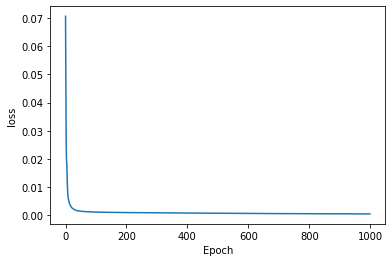

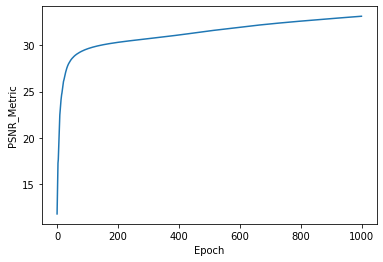

In [ ]:

epochs =  1000# @param {type:"number"}

#-------------Net_model----------------------------------------------------------------
model = UNetL2(input_size=(IMG_HEIGHT,IMG_WIDTH,L_bands))
model.compile(optimizer=optimizad, loss=loss,metrics = [PSNR_Metric])
history = model.fit(x=Y_inp,y=Y_oup, epochs=epochs)#, callbacks=[model_checkpoint_callback])
last_psnr=history.history['PSNR_Metric'][-1]
best_psnr=np.max(history.history['PSNR_Metric'])
iter_psnr=history.history['PSNR_Metric'].index(best_psnr)
best_loss=np.min(history.history['loss'])
iter_loss=history.history['loss'].index(best_loss)
name="VarianceScaling_Padd_Batch_seed_1234" # @param {type:"string"}
name+=', '+str(best_psnr)+', '+str(best_loss)+', '+str(epochs)+'.h5'
print(name)
model.save(old_cp_dir+name)

#.------------ seee the accfuracy---------------
plt.plot(history.history['loss'], label='loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.show()
plt.plot(history.history['PSNR_Metric'], label='PSNR_Metric')
plt.xlabel('Epoch')
plt.ylabel('PSNR_Metric')
plt.show()